In [41]:
# BACKPROPAGATION - how do gradients flow through the backwards pass in the computational graph 

In [42]:
# will use the softmax function -- take an input array and raise e to power of each item in the input array and divide by the sum 
# give you outputs between 0 to 1 and gives a sum of 1 

In [93]:
import numpy as np 

def softmax_func(normalized):
    raised = np.exp(normalized)
    output = raised / np.sum(raised, axis=1).reshape(-1,1)
    return output

In [94]:
x = np.random.rand(5,3) #corresponding to the last layer

y = np.zeros_like(x)
inds = (np.arange(0,y.shape[0]), np.random.randint(0, 3, size=y.shape[0]))
y[inds] = 1

In [95]:
x

array([[0.87525341, 0.89397031, 0.9109804 ],
       [0.08818043, 0.45584754, 0.52452548],
       [0.22001135, 0.20052407, 0.33348295],
       [0.8933896 , 0.43800177, 0.2005074 ],
       [0.40869798, 0.06433104, 0.69311554]])

In [96]:
y

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [97]:
normalized = x - np.max(x, axis=-1).reshape(-1,1)

normalized

array([[-0.03572699, -0.01701009,  0.        ],
       [-0.43634505, -0.06867795,  0.        ],
       [-0.1134716 , -0.13295888,  0.        ],
       [ 0.        , -0.45538782, -0.6928822 ],
       [-0.28441756, -0.6287845 ,  0.        ]])

In [98]:
softmax_func(normalized)

array([[0.32730374, 0.33348754, 0.33920872],
       [0.25053843, 0.36186797, 0.3875936 ],
       [0.32249103, 0.31626739, 0.36124158],
       [0.46853013, 0.29714273, 0.23432715],
       [0.32920114, 0.23329459, 0.43750428]])

In [99]:
np.finfo('float16').max

65500.0

In [100]:
a = np.array([0], dtype=np.float16)

a[0] = 6.55e50

/var/folders/mz/9zwpzjqs6m35hjp757412fjh0000gn/T/ipykernel_7271/2494835637.py:3: RuntimeWarning: overflow encountered in cast
  a[0] = 6.55e50


In [101]:
a

array([inf], dtype=float16)

In [102]:
#STAGED SOFTMAX FORWARD PASS

- Exp - we raise e to the power x.
- Sum - we add up the $e^x$ values for each row.
- Divide - we divide the $e^x$ values by the sums.

In [103]:
5 / 4

5 * 1/4

1/4

4**-1

0.25

- Exp
- Sum
- Pow - we invert the sum by raising to the power -1
- Multiply - we multiply the inverted sum and the exp values

In [104]:
raised = np.exp(x) #step 1
summed = np.sum(raised, axis=-1).reshape(-1,1) #step 2. reshape so each row has 1 column.
pow = summed ** -1 #step 3
staged_softmax = raised * pow #step 4

In [105]:
staged_softmax

array([[0.32730374, 0.33348754, 0.33920872],
       [0.25053843, 0.36186797, 0.3875936 ],
       [0.32249103, 0.31626739, 0.36124158],
       [0.46853013, 0.29714273, 0.23432715],
       [0.32920114, 0.23329459, 0.43750428]])

In [106]:
#STAGED SOFTMAX BACKWARD PASS

In [107]:
#REVERSE THE STAGE SOFTMAX AND COMPUTE THE GRADIENT

1. Start at the final step. Take in the loss gradient as the input, and multiply by the derivative of the final step.
2. Pass the gradient to the previous operation
3. Continue calculating the derivative of each operation, and multiplying by the gradient. Note that `Exp` is input to two operations, so it will sum both gradients.
4. Continue until we reach the first operation.

$NLL = -\sum_{i=0} y_{i} \log p_{i}$

* $\log p_{i}$ - the derivative of a natural log (base e) is $\frac{1}{p_{i}}$
* $-y_{i} * \log p_{i}$ - the derivative wrt p is $-y_{i}$

$\frac{1}{p} * -y_{i} = \frac{-y_{i}}{p_{i}}$

$\frac{\partial L}{\partial p}$

In [110]:
def nll_grad(y, pred):
    return -1 * y / pred

loss_grad = nll_grad(y, staged_softmax)

In [111]:
loss_grad

array([[-0.        , -0.        , -2.94803745],
       [-0.        , -2.76343883, -0.        ],
       [-0.        , -3.16188143, -0.        ],
       [-0.        , -0.        , -4.26753798],
       [-0.        , -0.        , -2.28569195]])

- Exp - the derivative of $e^x$ is $e^x$
- Sum - since a sum operation will combine input elements into one, we just distribute the gradient over all input elements. A change to any of the input elements will have a direct impact on the output. 
- Pow - the derivative of $x^{-1}$ is -1 * $x^{-2}$.
- Multiply - the derivatives of $x*y$ are $y$ wrt to $x$ wrt $y$. This is because any change to $x$ is multiplied by $y$, and vice versa. Thus the rate of change of $x$ is $y$, and vice versa.

In [112]:
raised = np.exp(x) #step 1
summed = np.sum(raised, axis=-1).reshape(-1,1) #step 2. reshape so each row has 1 column.
pow = summed ** -1 #step 3
staged_softmax = raised * pow #step 4

In [114]:
raised_grad = loss_grad * pow

pow_grad = loss_grad * raised
pow_grad = np.sum(pow_grad, axis=-1).reshape(-1,1) #reshape gradient to match input data 

summed_grad = (-1 * summed ** -2) * pow_grad

raised_grad_2 = np.ones_like(raised) * summed_grad #distribute gradient across inputs 

raised_grad += raised_grad_2 #sum incoming gradients 
staged_softmax_grad = raised_grad * np.exp(x)

In [115]:
staged_softmax_grad

array([[ 0.32730374,  0.33348754, -0.66079128],
       [ 0.25053843, -0.63813203,  0.3875936 ],
       [ 0.32249103, -0.68373261,  0.36124158],
       [ 0.46853013,  0.29714273, -0.76567285],
       [ 0.32920114,  0.23329459, -0.56249572]])

In [116]:
#ANALYTIC SOFTMAX

$S_{i}((i==j) - S_{j})$

[0.28, 0.25, 0.47]
.28
0,0 .28 * (1 - .28)
0,1 .28 * (0 - .25)

In [119]:
def softmax_grad_func(softmax, loss_grad):
    output = np.zeros_like(softmax)
    for i in range(softmax.shape[0]):
        sm_row = softmax[i,:]
        sm_grad = (-np.outer(sm_row, sm_row) + np.diag(sm_row.flatten()))
        row_grad = sm_grad * loss_grad[i,:].reshape(1,-1)
        output[i,:] = np.sum(row_grad, -1)
    return output

In [120]:
derived_softmax_grad = softmax_grad_func(staged_softmax, loss_grad)
derived_softmax_grad

array([[ 0.32730374,  0.33348754, -0.66079128],
       [ 0.25053843, -0.63813203,  0.3875936 ],
       [ 0.32249103, -0.68373261,  0.36124158],
       [ 0.46853013,  0.29714273, -0.76567285],
       [ 0.32920114,  0.23329459, -0.56249572]])

In [121]:
np.allclose(derived_softmax_grad, staged_softmax_grad)

True

In [ ]:
NLL(softmax(x), y)
softmax(x) - y

In [124]:
np.allclose(staged_softmax_grad, staged_softmax - y)

True

In [125]:
#SOFTMAX COMPUTATIONAL GRAPH

- `apply_fwd` - runs the forward pass up to the node it is called on.
- `apply_bwd` - runs the backward pass from the nose it is called on backwards.
- `zero_grad` - zero out our gradient before running a backward pass.
- `generate_graph` - helps us visualize the computational graph.
- `generate_derivative_chains` - shows us the equation for calculating the partial derivative at a node.

In [157]:
import sys, os

# Get the absolute path to the directory containing graph.py
module_path = os.path.abspath("/Users/sanskritiakhoury/Desktop/machine learning/Backpropagation")

# Append this directory to the system path
sys.path.append(module_path)

# Now you can import the graph module
from graph import Node, Parameter, display_chain

# Further code here

class Exp(Node):
    def forward(self, x):
        return np.exp(x) # raise e to the power x

    def backward(self, grad):
        x = self.cache[0] # Pull the x value used in the forward pass
        return np.exp(x) * grad # multiply the incoming gradient by the derivative

class Sum(Node):
    def forward(self, x):
        return np.sum(x, axis=-1).reshape(-1,1)

    def backward(self, grad):
        x = self.cache[0] # Pull the x value used in the forward pass
        return np.ones_like(x) * grad # distribute the gradient over the input data shape

class Pow(Node):
    def forward(self, x, exponent):
        return x ** exponent

    def backward(self, grad):
        x, exponent = self.cache # Pull the x and exponent values used in the forward pass
        return grad * exponent * x ** (exponent - 1), 1

class Multiply(Node):
    def forward(self, x, y):
        return x * y

    def backward(self, grad):
        x, y = self.cache # Pull the x and y values used in the forward pass
        return grad * y, grad * x

In [159]:
X = Parameter(x, desc="X", needs_grad=True)

raised = Exp(X, out="e^X")
summed = Sum(raised, out="sum(e^X)")

negative_one = Parameter(-1, desc="-1", needs_grad=False)

inverted = Pow(summed, negative_one, out="1/sum(e^X)")

softmax = Multiply(raised, inverted, out="softmax(X)")

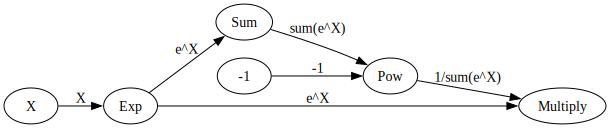

In [160]:
softmax.generate_graph()

In [161]:
operations_softmax = softmax.apply_fwd()

In [162]:
np.allclose(staged_softmax, operations_softmax)

True

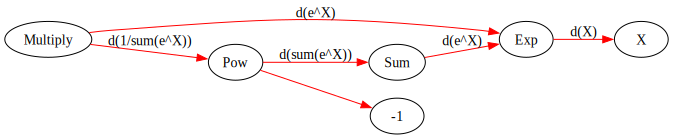

In [190]:
softmax.generate_graph(backward=True)

In [191]:
softmax.zero_grad()

softmax.apply_bwd(loss_grad)

operations_softmax_grad = X.grad

In [192]:
np.allclose(staged_softmax_grad, operations_softmax_grad)

True

In [194]:
#NEURAL NETWORK COMPUTATIONAL GRAPH

- `MathMul` - to multiply two matrices. The forward pass is `x@w`.
- `Add` - add two values up.
- `Relu` - a nonlinear activation function. Anything below `0` will be set to `0`.

In [197]:
class MatMul(Node):
    def forward(self, x, w):
        return x @ w # multiply the two matrices.

    def backward(self, grad):
        x, w = self.cache
        # return the input gradient times the weights as the gradient on x
        # the input x values (from the forward pass) times the input gradient is the gradient on the weights
        return grad @ w.T, x.T @ grad

class Add(Node):
    def forward(self, x, b):
        return x + b

    def backward(self, grad):
        # Any change to x or b will scale the output the same amount
        return grad, grad

class Relu(Node):
    def forward(self, x):
        return np.maximum(x, 0)

    def backward(self, grad):
        x = self.cache[0]
        new_grad = np.array(grad)
        # The derivative of relu is 0 when the input
        # in the forward pass was below 0
        # 1 otherwise
        new_grad[x < 0] = 0
        return new_grad

In [198]:
class Softmax(Node):
    def forward(self, x):
        return softmax_func(x)

    def backward(self, grad):
        x = self.cache[0]
        softmax = self.forward(x)
        return softmax_grad_func(softmax, grad)

class Dense(Node):
    def forward(self, x, w, b):
        # Multiply by weight, add bias
        return x @ w + b

    def backward(self, grad):
        x, w, b = self.cache
        # Return 3 gradients for x, w, and b
        return grad @ w.T, x.T @ grad, grad

In [204]:
# Get the absolute path to the directory containing graph.py
module_path = os.path.abspath("Desktop/machine learning/Backpropagation/csv_data.py")

# Append this directory to the system path
sys.path.append(module_path)
from csv_data import SkyServerDatasetWrapper

# Load the data
wrapper = SkyServerDatasetWrapper()
[train_x, train_y], [valid_x, valid_y], [test_x, test_y] = wrapper.get_flat_datasets()

Downloading...
From: https://drive.google.com/u/0/uc?id=1gYwg5YyaV3zUX-07bLCol8E0M-uX__zX&export=download
To: /Users/sanskritiakhoury/Desktop/machine learning/Backpropagation/skyserver.csv
100%|██████████████████████████████████████| 1.39M/1.39M [00:00<00:00, 11.9MB/s]
/Users/sanskritiakhoury/Desktop/machine learning/Backpropagation/csv_data.py:163: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[self.target] = data[self.target].replace({"STAR": 0, "GALAXY": 1, "QSO": 2})
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [205]:
train_x[:2]

array([[ 0.16745842, -0.58492272,  1.03148637, -0.34855938, -0.83728027,
        -0.94605772, -0.99534154, -0.83806089,  0.21085172, -0.21763043,
        -0.36973112,  1.03148936,  1.30931064],
       [ 0.16886159, -0.58311429,  0.05243046, -0.16653251, -0.15415531,
        -0.08264457, -0.02604308, -0.83806089,  0.21085172, -0.21763043,
        -0.36984929, -0.63621258, -0.87919741]])

We then need to one-hot encode our data so that we can use it for classification. We create 3-element vectors where only one element is 1, and the others are 0. The position of the 1 corresponds to the target we want to predict.

In [207]:
def encode(target, max_value=3):
    # A matrix with 3 columns
    encoded = np.zeros((target.shape[0], max_value))
    # Setup the indices that we'll set to one
    inds = (np.arange(0,target.shape[0]), target.reshape(-1))
    # Set the target positions to 1
    encoded[inds] = 1
    return encoded

train_y = encode(train_y)

In [208]:
train_y[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [209]:
# Set a seed so we can reproduce results
np.random.seed(0)
w1 = np.random.rand(13, 10)
b1 = np.random.rand(1, 10)
w2 = np.random.rand(10, 3)
b2 = np.random.rand(1, 3)

We can now define our network in code! This is very similar to networks we've built in the past. We have our first layer, with a relu activation, then our second layer, then a softmax to get probabilities:


In [210]:
X = Parameter(train_x, desc="X", needs_grad=False)
Y = Parameter(train_y, desc="y", needs_grad=False)

w1_param = Parameter(w1, desc="W1")
b1_param = Parameter(b1, desc="b1")

matmul1 = MatMul(X, w1_param, out="X @ W1")
add1 = Add(matmul1, b1_param, out="Z1")

layer1 = Relu(add1, out="A1")

w2_param = Parameter(w2, desc="W2")
b2_param = Parameter(b2, desc="b2")
matmul2 = MatMul(layer1, w2_param, out="Z1 @ W2")
add2 = Add(matmul2, b2_param, out="Z2")

softmax = Softmax(add2, out="softmax(Z2)")

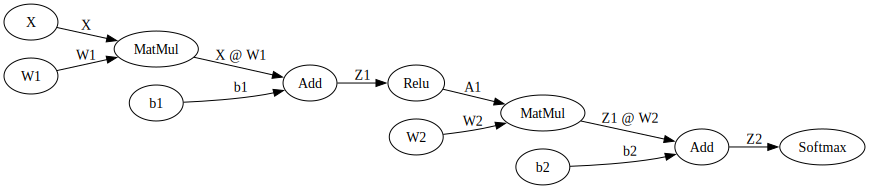

In [211]:
softmax.generate_graph()

We can create predictions using apply_fwd:

In [212]:
predictions = softmax.apply_fwd()

predictions[:2]

array([[0.51408579, 0.29557176, 0.19034245],
       [0.42508635, 0.26655849, 0.30835516]])

Now, we can run the backward pass of the network. We'll first graph it out:

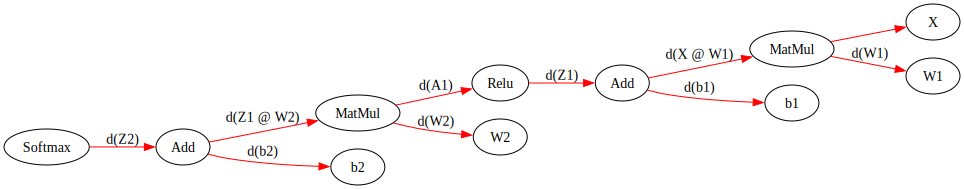

In [213]:
softmax.generate_graph(backward=True)

Then we'll run our backward pass. We first calculate our loss gradient, then pass it into our backward pass as the incoming gradient:

In [214]:
softmax.zero_grad() # zero out the gradients
loss_grad = nll_grad(train_y, predictions) # compute the loss gradient
softmax.apply_bwd(loss_grad) # pass the loss gradient into the softmax, and run the backward pass
softmax.generate_derivative_chains() # generate our derivative equations

In [215]:
w2_param.grad[:5]

array([[ 1078.86623385,  1452.92238635, -2531.7886202 ],
       [  685.34169939,  1438.06439063, -2123.40609002],
       [   11.39607931,  3488.94754329, -3500.3436226 ],
       [ 1990.1147882 ,   471.22083925, -2461.33562744],
       [ -538.48614737,  1989.95610171, -1451.46995434]])

In [218]:
display_chain(w2_param.display_partial_derivative()) #revisit this function -- theres a syntax error somewhere 

<IPython.core.display.Latex object>

In [219]:
display_chain(w1_param.display_partial_derivative())

<IPython.core.display.Latex object>

In [220]:
# Forward pass
l1 = train_x @ w1 + b1
l1_activated = np.maximum(l1, 0)
l2 = l1_activated @ w2 + b2
probs = softmax_func(l2)

# Loss
loss_grad = nll_grad(train_y, probs)

# L2 gradients
sm_grad = softmax_grad_func(probs, loss_grad)
l2_w_grad = l1_activated.T @ sm_grad
l2_b_grad = sm_grad.sum(axis=0)

# L1 gradients
l1_grad = sm_grad @ w2.T
l1_grad[l1 < 0] = 0
l1_w_grad = train_x.T @ l1_grad
l1_b_grad = l1_grad.sum(axis=0)

Then we can verify that our computational graph matches the manual results:

In [221]:
np.allclose(l1_w_grad, w1_param.grad)

True